In [1]:
import glob
import pandas as pd
from lfp_extracters import *
from sklearn.cross_validation import ShuffleSplit

import keras
from keras.models import Sequential
from keras import initializers 
from keras.layers import Dense, Activation, SimpleRNN, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, LSTM, Dropout

/opt/anaconda/miniconda2/envs/py34/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Data Loading 
#### From samples 1 to 1200, randomly select 80% to be in the train data set. If the number is even, it is in the Stimulus A folder; if it is odd, it is in the Stimulus B folder. 20% of the train data is chosen for validation. The remaining 20% of data comprises the test set. Indices are generated for five fold cross-validation.

In [2]:
def get_inds(): 
    
    numIter = 5
    rs = ShuffleSplit(1200, n_iter=numIter, test_size=.2, random_state=0)
    
    A_files = glob.glob('data/data/Stimulus_A/LFP_15_300/*.csv')
    B_files = glob.glob('data/data/Stimulus_B/LFP_15_300/*.csv')
    files = np.array(A_files + B_files)
    
    train_inds = []
    test_inds = []
    for train, test in rs: 
        train_inds.append(train)
        test_inds.append(test)
        
    train2 = []
    val_inds = []
    for t in train_inds: 
        s = ShuffleSplit(len(t), n_iter = 1, test_size = .2, random_state = 0)
        for train, val in s: 
            train2.append(train)
            val_inds.append(val)
        
    train_inds = train2
        
    return numIter, train_inds, val_inds, test_inds, files

In [3]:
def get_train_test_val(trial_num, train_inds, test_inds, val_inds, files):
    train_files = files[train_inds[trial_num]]
    test_files = files[test_inds[trial_num]]
    val_files = files[val_inds[trial_num]]
    return train_files, test_files, val_files

In [4]:
def make_test_df(test_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    l = []
    y_test = []
    bin_width = int(bin_width)
    
    for i in range(len(test_files)):
        n1 = np.genfromtxt(test_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        l.append(n_new.T) 
        if 'A' in test_files[i]: 
            y_test.append([0,1])
        else: 
            y_test.append([1,0])

    return np.array(l), y_test

In [5]:
def make_train_df(train_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_train = []
    bin_width = int(bin_width)
    
    for i in range(len(train_files)):
        n1 = np.genfromtxt(train_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new.T)
        if 'A' in train_files[i]: 
            y_train.append([0,1])
        else: 
            y_train.append([1,0])

    return np.array(list_), y_train

In [6]:
def make_val_df(val_files, with_time, bin_function, threshold, bin_width):
    channel_data = ['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', \
                   'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16']
    
    list_ = []
    y_val = []
    bin_width = int(bin_width)
    
    for i in range(len(val_files)):
        n1 = np.genfromtxt(val_files[i], delimiter = ',')
        if not with_time: 
            n1 = n1[0:16]
        n_new = bin_function(n1, threshold, bin_width)
        list_.append(n_new.T)
        if 'A' in val_files[i]: 
            y_val.append([0,1])
        else: 
            y_val.append([1,0])

    return np.array(list_), y_val

## Binning Metrics
#### Threshold Crossing Rate

In [11]:
def threshold_crossing_rate(x, threshold, bin_width): 
    inds = range(0, 6001, int(bin_width))
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        count_above = np.sum(abs(np.diff(sub > threshold)), axis = 1)/float(bin_width)
        if hastime:
            t_seg = np.reshape(t[inds[i]], (1,)) #uses time stamp at beginning of each bin
            count_above = np.concatenate((count_above, t_seg))
        newx.append(count_above)
    return np.array(newx)

#### Root Mean Square

In [12]:
def root_mean_square(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = []
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        rms = np.sqrt(np.mean(sub**2, axis = 1)) 
        
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

#### Gamma Band Power

In [13]:
def power_gamma_band(x, threshold, bin_width): 
    inds = range(0, 6001, bin_width)
    hastime = len(x) == 17
    newx = [] 
    #make bandpass filter for 30-100Hz 
    fs = 6000
    nyq = 0.5 * fs
    cutOff_L = 30
    cutOff_H = 100
    low = cutOff_L / nyq
    high = cutOff_H / nyq
    order = 2
    b, a = signal.butter(order, [low, high], btype='band')
    
    if hastime: 
        t = x[16]
    for i in range(0, len(inds) - 1): 
        sub = x[0:16, inds[i]:inds[i+1]]
        sub_f = signal.lfilter(b, a, sub)
        rms = np.sqrt(np.mean(sub_f**2, axis = 1))
        if hastime: 
            t_seg = np.reshape(t[inds[i]], (1,))
            rms = np.concatenate((rms, t_seg))
        newx.append(rms)
    return np.array(newx)

#### No Change -- filler function for running on raw data

In [14]:
def no_change(x, threshold, bin_width): 
    return x

### LSTM Model

In [92]:
def make_lstm(with_time, bin_width):
    model_lstm = Sequential()
    
    if with_time: 
        x = 17
    else: 
        x = 16
    
#     model_lstm.add(Dropout(0.3, input_shape=(x, 6000//bin_width)))
    model_lstm.add(LSTM(32, input_shape = (x, 6000//bin_width), return_sequences=False, recurrent_initializer = initializers.Identity(gain=1.0)))
#     model_lstm.add(LSTM(32, return_sequences = False, recurrent_initializer = initializers.Identity(gain=1.0)))
#     model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(128, activation = 'relu'))
#     model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(2, activation = 'softmax'))

    return model_lstm

### Fit, Predict

In [91]:
def makePredictions(model, train_df, train_l, test_df, test_l, val_df, val_l, with_time):
    a = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy',
                  optimizer=a,
                  metrics=['accuracy'])
    print('Fitting...')
    History = model.fit(train_df, train_l, epochs = 200, validation_data = (val_df, val_l))
    print('Predicting...')
    pred = model.predict(test_df)
    return pred, History

# Main

In [1]:
def main(): 
    
    numIter, train_inds, val_inds, test_inds, files = get_inds()    
    threshold = 0.010 
    bin_width = 265 
    bin_function = power_gamma_band
    with_time = False
    
    model = make_lstm(with_time, bin_width)
    
    preds = []
    actual = []
    
    for i in range(0, numIter): 
        print('Cross val iteration ' + str(i+1) +  ' of ' + str(numIter))
        train_files, test_files, val_files = get_train_test_val(i, train_inds, test_inds, val_inds, files)
        
        test_df, y_test = make_test_df(test_files, with_time, bin_function, threshold, bin_width)
        train_df, y_train = make_train_df(train_files, with_time, bin_function, threshold, bin_width)
        val_df, y_val = make_val_df(val_files, with_time, bin_function, threshold, bin_width)

        if with_time: 
            all_times = np.concatenate((train_df[:,-1,:], test_df[:,-1,:], val_df[:,-1,:])) 
            overall_time_mean = all_times.mean()
            overall_time_std = all_times.std() * 100
            new_times_train = (train_df[:,-1,:]-overall_time_mean)/overall_time_std
            new_times_test = (test_df[:,-1:]-overall_time_mean)/overall_time_std
            new_times_val = (val_df[:,-1,:]-overall_time_mean)/overall_time_std
            train_df[:,-1,:] = new_times_train
            test_df[:,-1,:] = np.reshape(new_times_test, (240, 6000//bin_width))
            val_df[:,-1,:] = new_times_val
        
        actual.append(y_test)
        
        pred, History = makePredictions(model, train_df, np.array(y_train), test_df, np.array(y_test),\
                                        val_df, np.array(y_val), with_time)

        preds.append(pred)
        
    return preds, actual, History

In [103]:
if __name__ == '__main__':
    preds, actual, History = main()

Cross val iteration 1 of 5
Fitting...
Train on 768 samples, validate on 192 samples
Epoch 1/200
768/768 [==============================] - 6s 8ms/step - loss: 0.6655 - acc: 0.6354 - val_loss: 0.6819 - val_acc: 0.5833
Epoch 2/200
768/768 [==============================] - 0s 430us/step - loss: 0.6617 - acc: 0.6354 - val_loss: 0.6794 - val_acc: 0.5833
Epoch 3/200
768/768 [==============================] - 0s 434us/step - loss: 0.6636 - acc: 0.6354 - val_loss: 0.6801 - val_acc: 0.5833
Epoch 4/200
768/768 [==============================] - 0s 414us/step - loss: 0.6613 - acc: 0.6354 - val_loss: 0.6831 - val_acc: 0.5833
Epoch 5/200
768/768 [==============================] - 0s 437us/step - loss: 0.6574 - acc: 0.6354 - val_loss: 0.6829 - val_acc: 0.5833
Epoch 6/200
768/768 [==============================] - 0s 446us/step - loss: 0.6577 - acc: 0.6354 - val_loss: 0.6810 - val_acc: 0.5833
Epoch 7/200
768/768 [==============================] - 0s 427us/step - loss: 0.6565 - acc: 0.6354 - val_loss

Epoch 61/200
768/768 [==============================] - 0s 445us/step - loss: 0.6545 - acc: 0.6354 - val_loss: 0.6830 - val_acc: 0.5833
Epoch 62/200
768/768 [==============================] - 0s 437us/step - loss: 0.6540 - acc: 0.6354 - val_loss: 0.6786 - val_acc: 0.5833
Epoch 63/200
768/768 [==============================] - 0s 450us/step - loss: 0.6545 - acc: 0.6354 - val_loss: 0.6814 - val_acc: 0.5833
Epoch 64/200
768/768 [==============================] - 0s 421us/step - loss: 0.6553 - acc: 0.6354 - val_loss: 0.6796 - val_acc: 0.5833
Epoch 65/200
768/768 [==============================] - 0s 418us/step - loss: 0.6560 - acc: 0.6354 - val_loss: 0.6797 - val_acc: 0.5833
Epoch 66/200
768/768 [==============================] - 0s 438us/step - loss: 0.6500 - acc: 0.6354 - val_loss: 0.6963 - val_acc: 0.5833
Epoch 67/200
768/768 [==============================] - 0s 423us/step - loss: 0.6501 - acc: 0.6354 - val_loss: 0.6703 - val_acc: 0.5833
Epoch 68/200
768/768 [==========================

768/768 [==============================] - 0s 445us/step - loss: 0.4893 - acc: 0.7799 - val_loss: 0.5096 - val_acc: 0.7656
Epoch 122/200
768/768 [==============================] - 0s 450us/step - loss: 0.5049 - acc: 0.7643 - val_loss: 0.5093 - val_acc: 0.7917
Epoch 123/200
768/768 [==============================] - 0s 469us/step - loss: 0.4912 - acc: 0.7799 - val_loss: 0.5052 - val_acc: 0.7604
Epoch 124/200
768/768 [==============================] - 0s 438us/step - loss: 0.4947 - acc: 0.7773 - val_loss: 0.4986 - val_acc: 0.7812
Epoch 125/200
768/768 [==============================] - 0s 453us/step - loss: 0.4855 - acc: 0.7891 - val_loss: 0.5555 - val_acc: 0.7396
Epoch 126/200
768/768 [==============================] - 0s 485us/step - loss: 0.4914 - acc: 0.7917 - val_loss: 0.4942 - val_acc: 0.7917
Epoch 127/200
768/768 [==============================] - 0s 433us/step - loss: 0.4883 - acc: 0.7786 - val_loss: 0.4937 - val_acc: 0.7708
Epoch 128/200
768/768 [==============================] 

Epoch 181/200
768/768 [==============================] - 0s 433us/step - loss: 0.4571 - acc: 0.8060 - val_loss: 0.4916 - val_acc: 0.7969
Epoch 182/200
768/768 [==============================] - 0s 431us/step - loss: 0.4603 - acc: 0.8021 - val_loss: 0.4836 - val_acc: 0.7865
Epoch 183/200
768/768 [==============================] - 0s 425us/step - loss: 0.4730 - acc: 0.7982 - val_loss: 0.5100 - val_acc: 0.7760
Epoch 184/200
768/768 [==============================] - 0s 423us/step - loss: 0.4592 - acc: 0.7969 - val_loss: 0.5081 - val_acc: 0.7969
Epoch 185/200
768/768 [==============================] - 0s 406us/step - loss: 0.4715 - acc: 0.7917 - val_loss: 0.4843 - val_acc: 0.7812
Epoch 186/200
768/768 [==============================] - 0s 443us/step - loss: 0.4579 - acc: 0.8034 - val_loss: 0.4874 - val_acc: 0.8021
Epoch 187/200
768/768 [==============================] - 0s 440us/step - loss: 0.4519 - acc: 0.8060 - val_loss: 0.4912 - val_acc: 0.7865
Epoch 188/200
768/768 [==================

768/768 [==============================] - 0s 456us/step - loss: 0.4211 - acc: 0.8281 - val_loss: 0.5159 - val_acc: 0.7917
Epoch 101/200
768/768 [==============================] - 0s 454us/step - loss: 0.4075 - acc: 0.8359 - val_loss: 0.4994 - val_acc: 0.7865
Epoch 102/200
768/768 [==============================] - 0s 433us/step - loss: 0.4020 - acc: 0.8424 - val_loss: 0.4903 - val_acc: 0.8177
Epoch 103/200
768/768 [==============================] - 0s 436us/step - loss: 0.4045 - acc: 0.8346 - val_loss: 0.5407 - val_acc: 0.7760
Epoch 104/200
768/768 [==============================] - 0s 438us/step - loss: 0.4065 - acc: 0.8385 - val_loss: 0.5085 - val_acc: 0.8073
Epoch 105/200
768/768 [==============================] - 0s 443us/step - loss: 0.4012 - acc: 0.8333 - val_loss: 0.4907 - val_acc: 0.8073
Epoch 106/200
768/768 [==============================] - 0s 435us/step - loss: 0.4096 - acc: 0.8320 - val_loss: 0.5032 - val_acc: 0.7865
Epoch 107/200
768/768 [==============================] 

Epoch 160/200
768/768 [==============================] - 0s 446us/step - loss: 0.3904 - acc: 0.8503 - val_loss: 0.4923 - val_acc: 0.7969
Epoch 161/200
768/768 [==============================] - 0s 431us/step - loss: 0.3896 - acc: 0.8464 - val_loss: 0.5080 - val_acc: 0.7969
Epoch 162/200
768/768 [==============================] - 0s 435us/step - loss: 0.3901 - acc: 0.8464 - val_loss: 0.4901 - val_acc: 0.7969
Epoch 163/200
768/768 [==============================] - 0s 456us/step - loss: 0.3946 - acc: 0.8464 - val_loss: 0.5172 - val_acc: 0.7917
Epoch 164/200
768/768 [==============================] - 0s 457us/step - loss: 0.3944 - acc: 0.8568 - val_loss: 0.4912 - val_acc: 0.8125
Epoch 165/200
768/768 [==============================] - 0s 484us/step - loss: 0.4062 - acc: 0.8438 - val_loss: 0.4738 - val_acc: 0.8125
Epoch 166/200
768/768 [==============================] - 0s 469us/step - loss: 0.4000 - acc: 0.8477 - val_loss: 0.4898 - val_acc: 0.8177
Epoch 167/200
768/768 [==================

768/768 [==============================] - 0s 487us/step - loss: 0.3542 - acc: 0.8776 - val_loss: 0.5092 - val_acc: 0.8073
Epoch 80/200
768/768 [==============================] - 0s 504us/step - loss: 0.3360 - acc: 0.8724 - val_loss: 0.5056 - val_acc: 0.8229
Epoch 81/200
768/768 [==============================] - 0s 438us/step - loss: 0.3220 - acc: 0.8828 - val_loss: 0.5977 - val_acc: 0.7604
Epoch 82/200
768/768 [==============================] - 0s 429us/step - loss: 0.3428 - acc: 0.8659 - val_loss: 0.5614 - val_acc: 0.7812
Epoch 83/200
768/768 [==============================] - 0s 452us/step - loss: 0.3685 - acc: 0.8490 - val_loss: 0.5543 - val_acc: 0.7552
Epoch 84/200
768/768 [==============================] - 0s 445us/step - loss: 0.3489 - acc: 0.8763 - val_loss: 0.5278 - val_acc: 0.7917
Epoch 85/200
768/768 [==============================] - 0s 428us/step - loss: 0.3413 - acc: 0.8724 - val_loss: 0.5526 - val_acc: 0.7812
Epoch 86/200
768/768 [==============================] - 0s 43

768/768 [==============================] - 0s 462us/step - loss: 0.3168 - acc: 0.8815 - val_loss: 0.5874 - val_acc: 0.7708
Epoch 140/200
768/768 [==============================] - 0s 464us/step - loss: 0.3232 - acc: 0.8828 - val_loss: 0.6609 - val_acc: 0.7500
Epoch 141/200
768/768 [==============================] - 0s 458us/step - loss: 0.3461 - acc: 0.8620 - val_loss: 0.6734 - val_acc: 0.7344
Epoch 142/200
768/768 [==============================] - 0s 451us/step - loss: 0.3486 - acc: 0.8685 - val_loss: 0.4744 - val_acc: 0.8281
Epoch 143/200
768/768 [==============================] - 0s 476us/step - loss: 0.3228 - acc: 0.8841 - val_loss: 0.5310 - val_acc: 0.7812
Epoch 144/200
768/768 [==============================] - 0s 452us/step - loss: 0.3250 - acc: 0.8841 - val_loss: 0.5875 - val_acc: 0.7812
Epoch 145/200
768/768 [==============================] - 0s 440us/step - loss: 0.2991 - acc: 0.8932 - val_loss: 0.6030 - val_acc: 0.7865
Epoch 146/200
768/768 [==============================] 

Epoch 199/200
768/768 [==============================] - 0s 451us/step - loss: 0.3661 - acc: 0.8633 - val_loss: 0.5764 - val_acc: 0.7969
Epoch 200/200
768/768 [==============================] - 0s 437us/step - loss: 0.3022 - acc: 0.8880 - val_loss: 0.6018 - val_acc: 0.7760
Predicting...
Cross val iteration 4 of 5
Fitting...
Train on 768 samples, validate on 192 samples
Epoch 1/200
768/768 [==============================] - 6s 8ms/step - loss: 0.3304 - acc: 0.8802 - val_loss: 0.5413 - val_acc: 0.7969
Epoch 2/200
768/768 [==============================] - 0s 421us/step - loss: 0.2981 - acc: 0.8893 - val_loss: 0.5780 - val_acc: 0.7917
Epoch 3/200
768/768 [==============================] - 0s 461us/step - loss: 0.2962 - acc: 0.8893 - val_loss: 0.7688 - val_acc: 0.7448
Epoch 4/200
768/768 [==============================] - 0s 440us/step - loss: 0.3246 - acc: 0.8750 - val_loss: 0.6323 - val_acc: 0.7760
Epoch 5/200
768/768 [==============================] - 0s 427us/step - loss: 0.2855 - acc:

768/768 [==============================] - 0s 451us/step - loss: 0.2511 - acc: 0.9062 - val_loss: 0.6903 - val_acc: 0.7865
Epoch 119/200
768/768 [==============================] - 0s 450us/step - loss: 0.2465 - acc: 0.9115 - val_loss: 0.7532 - val_acc: 0.7656
Epoch 120/200
768/768 [==============================] - 0s 462us/step - loss: 0.2604 - acc: 0.8932 - val_loss: 0.6921 - val_acc: 0.7812
Epoch 121/200
768/768 [==============================] - 0s 458us/step - loss: 0.2661 - acc: 0.8958 - val_loss: 0.7352 - val_acc: 0.7917
Epoch 122/200
768/768 [==============================] - 0s 441us/step - loss: 0.2333 - acc: 0.9180 - val_loss: 0.7899 - val_acc: 0.7865
Epoch 123/200
768/768 [==============================] - 0s 447us/step - loss: 0.2467 - acc: 0.9076 - val_loss: 0.8445 - val_acc: 0.7656
Epoch 124/200
768/768 [==============================] - 0s 443us/step - loss: 0.2420 - acc: 0.9115 - val_loss: 0.9047 - val_acc: 0.7708
Epoch 125/200
768/768 [==============================] 

Epoch 178/200
768/768 [==============================] - 0s 441us/step - loss: 0.2378 - acc: 0.9089 - val_loss: 0.7788 - val_acc: 0.7604
Epoch 179/200
768/768 [==============================] - 0s 458us/step - loss: 0.2422 - acc: 0.9193 - val_loss: 0.7308 - val_acc: 0.7917
Epoch 180/200
768/768 [==============================] - 0s 473us/step - loss: 0.2284 - acc: 0.9206 - val_loss: 0.7905 - val_acc: 0.7760
Epoch 181/200
768/768 [==============================] - 0s 439us/step - loss: 0.2077 - acc: 0.9271 - val_loss: 0.9147 - val_acc: 0.7760
Epoch 182/200
768/768 [==============================] - 0s 453us/step - loss: 0.2171 - acc: 0.9219 - val_loss: 0.8044 - val_acc: 0.7708
Epoch 183/200
768/768 [==============================] - 0s 469us/step - loss: 0.2148 - acc: 0.9232 - val_loss: 0.7834 - val_acc: 0.7760
Epoch 184/200
768/768 [==============================] - 0s 422us/step - loss: 0.2374 - acc: 0.9102 - val_loss: 0.8204 - val_acc: 0.7604
Epoch 185/200
768/768 [==================

768/768 [==============================] - 0s 459us/step - loss: 0.1953 - acc: 0.9258 - val_loss: 1.0696 - val_acc: 0.7760
Epoch 98/200
768/768 [==============================] - 0s 483us/step - loss: 0.2177 - acc: 0.9141 - val_loss: 0.8011 - val_acc: 0.7760
Epoch 99/200
768/768 [==============================] - 0s 440us/step - loss: 0.2624 - acc: 0.8958 - val_loss: 0.8435 - val_acc: 0.7656
Epoch 100/200
768/768 [==============================] - 0s 458us/step - loss: 0.2331 - acc: 0.9102 - val_loss: 1.2232 - val_acc: 0.7292
Epoch 101/200
768/768 [==============================] - 0s 443us/step - loss: 0.2657 - acc: 0.8971 - val_loss: 1.2640 - val_acc: 0.7292
Epoch 102/200
768/768 [==============================] - 0s 458us/step - loss: 0.2343 - acc: 0.9128 - val_loss: 0.8286 - val_acc: 0.7865
Epoch 103/200
768/768 [==============================] - 0s 503us/step - loss: 0.2278 - acc: 0.9167 - val_loss: 0.9523 - val_acc: 0.7812
Epoch 104/200
768/768 [==============================] - 

In [ ]:
preds

In [104]:
preds = np.around(preds, decimals = 0)
preds.shape

(5, 240, 2)

#### Plot Learning Curves

In [25]:
import matplotlib.pyplot as plt 
%matplotlib inline

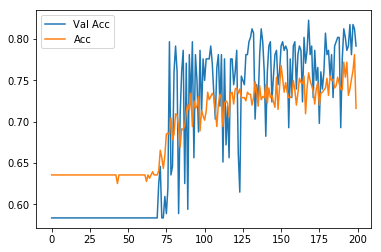

In [42]:
plt.plot(History.history['val_acc'])
plt.plot(History.history['acc'])
plt.legend(['Val Acc', 'Acc'])
plt.show()

#### Compute Model Accuracy

In [105]:
totals = []
for i in range(0, len(preds)): 
    current_pred = preds[i]
    current_real = actual[i]
    total = 0
    for j in range(0, len(preds[i])):
        if current_pred[j][0] == current_real[j][0]: 
            total += 1
    totals.append(total)
    
totals

[178, 188, 191, 201, 191]

In [106]:
i = 0
accs = []
for t in totals: 
    acc = t/len(preds[i])
    i+=1
    accs.append(acc)
accs

[0.7416666666666667,
 0.7833333333333333,
 0.7958333333333333,
 0.8375,
 0.7958333333333333]

In [107]:
np.std(accs)

0.030663949154956825

In [108]:
np.mean(accs)

0.7908333333333333